In [1]:
import torch
import math 
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

In [2]:
def generate_disc_set(nb):
    input_ = torch.empty(nb, 2).uniform_(0,1)
    target_ = torch.empty(nb,2)
    
    for i in range(nb):
        if (torch.norm(input_[i]) < math.sqrt(1/(2*math.pi))):
            target_[i,0] = 0
            target_[i,1] = 1
        else : 
            target_[i,0] = 1
            target_[i,1] = 0
    return input_, target_

# Data generation 

Size of the input =  torch.Size([1000, 2])
Size of the target =  torch.Size([1000, 2])


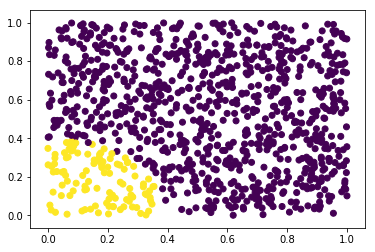

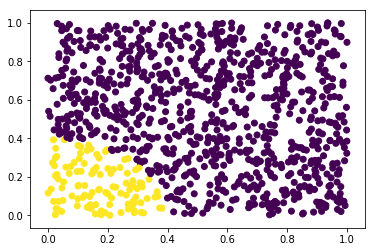

888.0


In [3]:
train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

print('Size of the input = ', train_input.size())
print('Size of the target = ', train_target.size())

plt.scatter(train_input[:,0],train_input[:,1], c = torch.argmax(train_target,dim = 1))
plt.show()

plt.scatter(test_input[:,0],test_input[:,1], c = torch.argmax(test_target,dim = 1))
plt.show()

print(torch.sum(test_target, dim = 0)[0].item())

## Loss

In [4]:
def LossMSE(v, t):
    return torch.sum(torch.pow(t - v, 2)).item() #1 x 2
    
def d_LossMSE(v, t):
    return (2*(v-t)) #100 x 2 

## Classes

In [5]:
class Module(object):
    
    def forward_pass(self, *_input_):
        raise NotImplementedError

    def backward_pass(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []
    
    def update(self, eta):
        return [] 
    
    def zerograd(self):
        return []    

In [6]:
class Linear(Module):
    
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialization of paramaters (weights and biases and their gradients)
        std_init_w = math.sqrt(2/(self.in_features + self.out_features))
        self.w = torch.empty(out_features,in_features).normal_(0,std_init_w)
        std_init_b = 1/math.sqrt(self.w.size(1))
        self.b = torch.empty(out_features).uniform_(-std_init_b,std_init_b) 
        
        #self.w = torch.ones(out_features,in_features)
        #self.b = torch.zeros(out_features)
        
        self.dl_dw = torch.zeros(self.w.size())
        self.dl_db = torch.zeros(self.b.size())
        
        self.cache_input_act = None
    
    def forward_pass(self, _input_):
        self.cache_input_act = _input_ # 100 x 25
        s = _input_ @ self.w.t() + self.b  #100 (batch_size) x 25
        return s

    def backward_pass(self, gradwrtoutput):
        dl_dx =  gradwrtoutput @ self.w # 100 x 25 
        self.dl_dw =  gradwrtoutput.t() @ self.cache_input_act # 2 x 25
        self.dl_db = torch.sum(gradwrtoutput, dim = 0) # We want 2 x 1
        return dl_dx
        
    def param(self):
        return [(self.w, self.dl_dw), (self.b, self.dl_db)]
     
    def update(self, eta):
        self.w -= eta * self.dl_dw
        self.b -= eta * self.dl_db
        
    def zerograd(self):
        self.dl_dw = torch.zeros(self.w.size())
        self.dl_db = torch.zeros(self.b.size())
        
class ReLU(Module):
    
    def __init__(self):
        super(ReLU, self).__init__()
        self.cache_input_linear = None
    
    def ReLU_fun(self,_input_):
        return _input_ * (_input_ > 0).float()
    
    def d_ReLU(self,_input_):
        return 1. * (_input_ > 0).float()

    def forward_pass(self, _input_):
        self.cache_input_linear = _input_
        x = self.ReLU_fun(_input_) #100 x 25
        return x

    def backward_pass(self, gradwrtoutput):
        dl_ds =  self.d_ReLU(self.cache_input_linear) * gradwrtoutput # 100 x 2
        self.cache_input_linear = None
        return dl_ds
        
class Tanh(Module):
    
    def __init__(self):
        super(Tanh, self).__init__()
        self.cache_input_linear = None
        
    def Tanh_fun(self,_input_):
        return _input_.tanh()
    
    def d_Tanh(self,_input_):
        return (1 - torch.pow(self.Tanh_fun(_input_), 2))

    def forward_pass(self, _input_):
        self.cache_input_linear = _input_
        x = self.Tanh_fun(_input_) #100 x 25
        return x
   
    def backward_pass(self, gradwrtoutput):
        dl_ds =  self.d_Tanh(self.cache_input_linear) * gradwrtoutput # 100 x 2
        self.cache_input_linear = None
        return dl_ds
    
class Sigmoid(Module):
    
    def __init__(self):
        super(Sigmoid, self).__init__()
        self.cache_input_linear = None
        
    def Sigmoid_fun(self,_input_):
        return 1/(1+torch.exp(-_input_))
    
    def d_Sigmoid(self,_input_):
        return torch.exp(-_input_)/torch.pow((1+torch.exp(-_input_)),2)

    def forward_pass(self, _input_):
        self.cache_input_linear = _input_
        x = self.Sigmoid_fun(_input_) #100 x 25
        return x
   
    def backward_pass(self, gradwrtoutput):
        dl_ds =  self.d_Sigmoid(self.cache_input_linear) * gradwrtoutput # 100 x 2
        self.cache_input_linear = None
        return dl_ds

In [7]:
class Sequential(Module):
    
    def __init__(self, *args):
        super(Sequential, self).__init__()
        self.modules = []
        self.forward = None
        self.backward = None
        for module in args:
            self.modules.append(module)
    
    def forward_pass(self, _input_):
        self.forward = _input_
        for module in self.modules:
            self.forward = module.forward_pass(self.forward)
        return self.forward
            
    def backward_pass(self, target):
        self.backward = d_LossMSE(self.forward, target) #100 x 2
        for module in reversed(self.modules):
            self.backward = module.backward_pass(self.backward)
    
    def zerograd(self):
        for module in self.modules:
            module.zerograd()
            
    def update(self, eta):
        for module in self.modules:
            if(len(module.param()) > 0):
                module.update(eta) # Maybe we should change eta over time 

In [8]:
def train(model, train_input, train_target, eta, batch_size, epochs):
    losses = []
    for e in range(epochs):
        batch_loss = 0 
        for input_, target_ in zip(train_input.split(batch_size), train_target.split(batch_size)):
            output_ = model.forward_pass(input_)
            batch_loss += LossMSE(output_, target_)
            model.backward_pass(target_)
            model.update(eta)
            model.zerograd()
        losses.append(batch_loss)
    return losses

In [9]:
def error(output, target):
    errors = 0
    indices = []
    for i in range(target.size()[0]):
        if (torch.argmax(output[i,:]) != torch.argmax(target[i,:])):
            errors += 1
            indices.append(i)
    return errors, indices

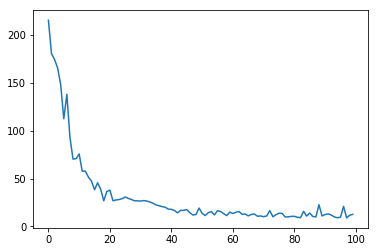

In [28]:
eta = 0.01
mini_batch_size = 100
epochs = 25

model = Sequential(Linear(2,25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), Sigmoid())

losses = train(model, train_input, train_target, eta, mini_batch_size, epochs)
plt.plot(losses)


5
2


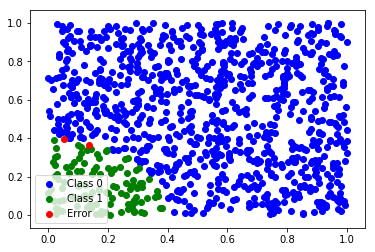

In [29]:
output_train = model.forward_pass(train_input)
output_test = model.forward_pass(test_input)

errors_train, indices_train = error(output_train, train_target)
print(errors_train)
errors_test, indices_test = error(output_test, test_target)
print(errors_test)

test = torch.argmax(test_target, dim =1)
test[indices_test] = 2

plt.scatter(test_input[test==0,0],test_input[test==0,1], c = 'blue')
plt.scatter(test_input[test==1,0],test_input[test==1,1], c = 'green')
plt.scatter(test_input[test==2,0],test_input[test==2,1], c = 'red')
plt.legend(['Class 0','Class 1','Error'])
plt.show()

In [32]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
torch.set_grad_enabled(True)

def train_model(model, train_input, train_target):
    lr, nb_epochs, batch_size = 1e-2, 25, 100
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    criterion = nn.MSELoss()
    
    for e in range(nb_epochs):
        for input_, target_ in zip(train_input.split(batch_size), train_target.split(batch_size)):
            output_ = model(input_)
            loss = criterion(output_, target_) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            
model = nn.Sequential(nn.Linear(2, 25), nn.ReLU(),
                         nn.Linear(25, 25), nn.ReLU(),
                         nn.Linear(25, 25), nn.ReLU(),
                         nn.Linear(25, 2), nn.Sigmoid())
            
train_model(model, train_input, train_target)

output = model(test_input)
errors, indices = error(output, test_target)
print(errors)

test = torch.argmax(test_target, dim =1)
test[indices] = 2

3


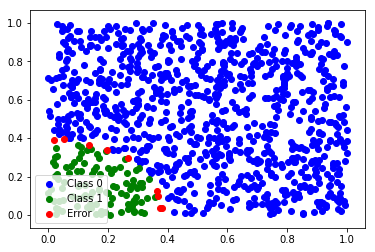

In [31]:
plt.scatter(test_input[test==0,0],test_input[test==0,1], c = 'blue')
plt.scatter(test_input[test==1,0],test_input[test==1,1], c = 'green')
plt.scatter(test_input[test==2,0],test_input[test==2,1], c = 'red')
plt.legend(['Class 0','Class 1','Error'])
plt.show()